In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
import camb
from tqdm import tqdm
import healpy
import pickle
import cosmoped

2024-03-10 17:42:24.168973: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


ModuleNotFoundError: No module named 'cosmoped'

In [25]:
fid = [69.8 , 0.0224, 0.12,  3.0753, 0.965]
fid_dls = simulator(fid) 
cls = np.load('cls.npy')
params = np.load('params.npy')
observed_dataset = torch.tensor(np.load('obs.npy'), dtype = torch.float32)

In [16]:
def simulator(params):
    pars = camb.CAMBparams()
    H0 = params[0] 
    As = 1e-10*np.exp(params[3])
    pars.set_cosmology(H0=H0, ombh2=params[1], omch2=params[2])
    pars.InitPower.set_params(As=As, ns=params[4])
    pars.set_for_lmax(2500, lens_potential_accuracy=0)
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
    total = powers['total']
    cl = total[:, 0]
    return cl[2:]



['/Users/aisulu/Desktop/gcloud_files', '/Users/aisulu/anaconda3/envs/myenv/lib/python38.zip', '/Users/aisulu/anaconda3/envs/myenv/lib/python3.8', '/Users/aisulu/anaconda3/envs/myenv/lib/python3.8/lib-dynload', '', '/Users/aisulu/anaconda3/envs/myenv/lib/python3.8/site-packages']


In [5]:
import numpy as np
import sys 
path_to_file = '/Users/aisulu/Desktop/moped_sbi/cosmoped'
if path_to_file not in sys.path:
    sys.path.append(path_to_file)

from cosmoped_likelihood import CosMOPED
import healpy as hp



In [6]:
path='LambdaCDM/'
TT2018=CosMOPED(path, year=2018, spectra='TT', use_low_ell_bins=False)
compression_vector_dict, compressed_data_dict = TT2018.read_compression_vectors_and_compressed_data(path)
compress_vec_h = compression_vector_dict['h']
compress_vec_ombh2 = compression_vector_dict['omega_b']
compress_vec_omch2 = compression_vector_dict['omega_cdm']
compress_vec_As = compression_vector_dict['A_s']
compress_vec_ns = compression_vector_dict['n_s']
def sim(params):
    # Create a set of cosmological parameters
    pars = camb.CAMBparams()
    H0 = params[0] * 100
    As = params[3]
    pars.set_cosmology(H0=H0, ombh2=params[1], omch2=params[2])
    pars.InitPower.set_params(As=As, ns=params[4])
    pars.set_for_lmax(2500, lens_potential_accuracy=0)

    # Get the results from CAMB
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
    cl = powers['total'][:, 0]
    nside = 1024
    cmb_map = hp.sphtfunc.synfast(cl, nside=nside)
    dl_hats = hp.sphtfunc.anafast(cmb_map)
    dltt = dl_hats[2:2509]
    ells = np.arange(2510)[2:2509]
    return dltt, ells

def compress(dltt, ells):
    fac = fac=ells*(ells+1)/(2*np.pi)
    cltt = dltt/fac
    return [compress_vec_h.dot(cltt), compress_vec_ombh2.dot(cltt), compress_vec_omch2.dot(cltt), compress_vec_As.dot(cltt),
            compress_vec_ns.dot(cltt)]

def sim_wrapper(param):
    dltt, ells = sim(param)
    return compress(dltt, ells)

observed_params = torch.tensor([0.67, 0.022, 0.120, 2.1955e-9, 0.966])

# Generate the observed dataset
observed_dataset = sim_wrapper(observed_params)
print(observed_dataset )

[-144.9157301338773, -320.4281287396788, -267.18132755913535, 415.18756460906417, 11.640713595807718]


Running 3000 simulations.:   0%|          | 0/3000 [00:00<?, ?it/s]

 Neural network successfully converged after 190 epochs.

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

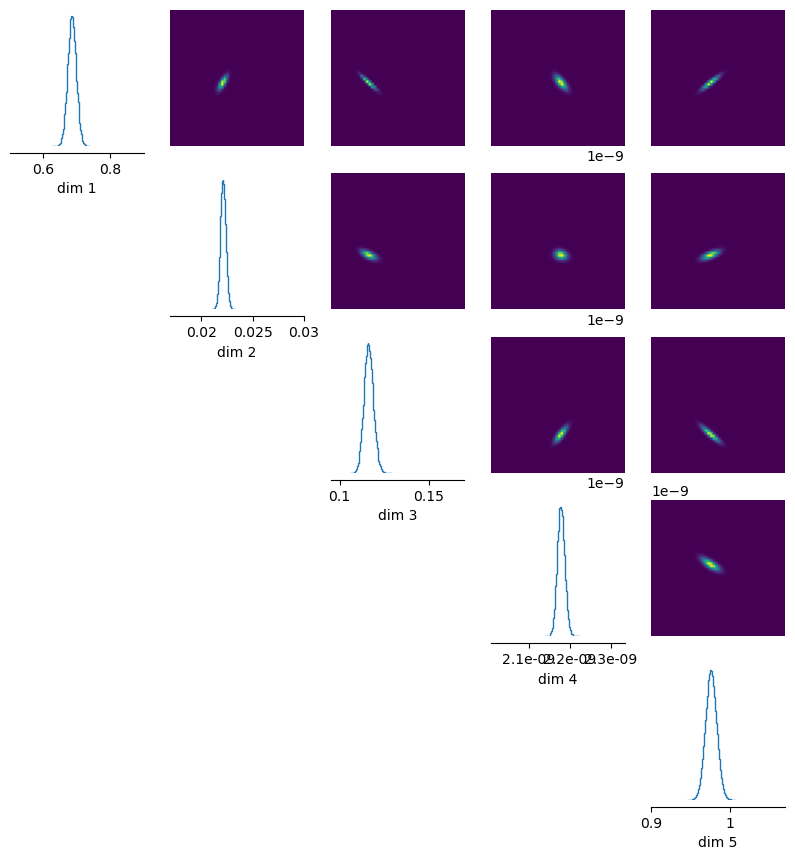

In [7]:
parameter_min = [0.50, 0.017, 0.095, 1e-10*np.exp(3.00), 0.9]
parameter_max = [0.90, 0.03, 0.17,1e-10*np.exp(3.15), 1.07]

# Define prior for all parameters
prior = utils.BoxUniform(low=torch.as_tensor(parameter_min),
                         high=torch.as_tensor(parameter_max))

num_sim = 3000
# Run SBI to perform inference
posterior = infer(sim_wrapper, prior, method='SNPE',
                  num_simulations=num_sim, num_workers=1)

num_samples = 100000
# Draw samples from the posterior
samples = posterior.sample((num_samples,), x=observed_dataset)

np.save(f'sbi_cosmoped_{num_sim}_{num_samples}_5d_noise.npy', samples)

with open(f'posterior_{num_sim}_SNPE_cosmoped_5d_noise.pkl', 'wb') as file:
    pickle.dump(posterior, file)

# Analyze the results (for example, by plotting the posterior)
limits_plot = [[parameter_min[i], parameter_max[i]] for i in range(len(parameter_min))]
_ = analysis.pairplot(samples, limits=limits_plot,
                      figsize=(10,10))

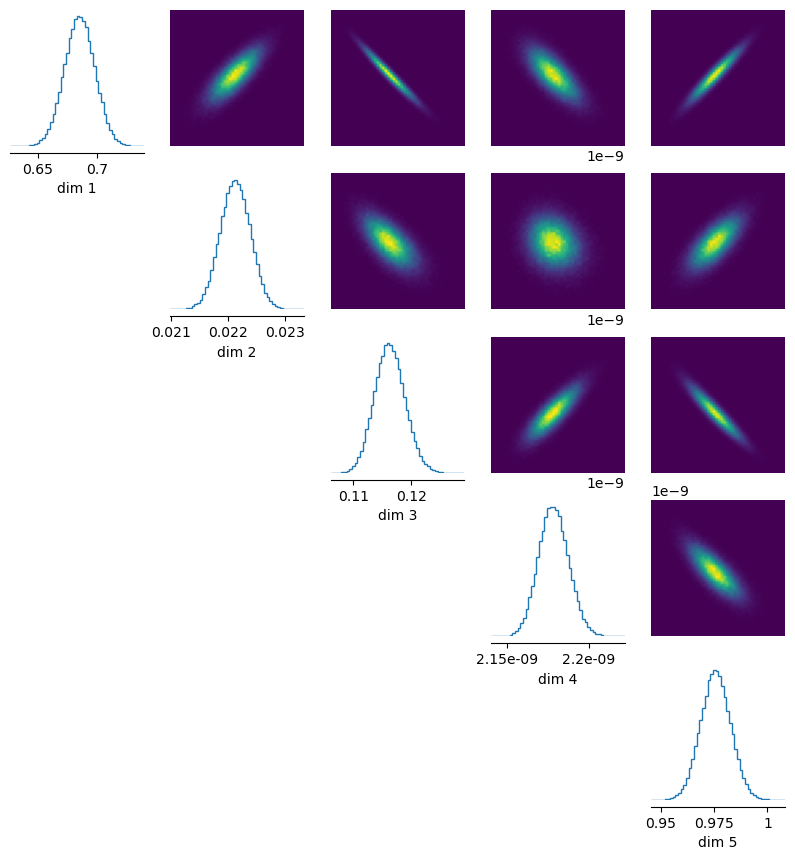

In [8]:
limits_plot = [[parameter_min[i], parameter_max[i]] for i in range(len(parameter_min))]
_ = analysis.pairplot(samples,
                      figsize=(10,10))

In [46]:
import pickle
with open('moped_sbi_posterior.pkl', "wb") as file:
    pickle.dump(posterior, file)

In [47]:
import getdist

In [84]:
data = np.loadtxt('montemcmc_files/2024-02-24_10000__1.txt')
data = np.concatenate((data,np.loadtxt('montemcmc_files/2024-02-25_10000__1.txt')),axis=0)
data = np.concatenate((data,np.loadtxt('montemcmc_files/2024-02-25_20000__3.txt')),axis=0)
data = np.concatenate((data,np.loadtxt('montemcmc_files/2024-02-25_20000__4.txt')),axis=0)
data = np.concatenate((data,np.loadtxt('montemcmc_files/2024-02-25_30000__1.txt')),axis=0)

In [81]:
print(data[0])

[2.000000e+00 4.265780e+02 7.100524e-01 2.274509e+00 1.109580e-01
 2.390266e+00 9.643025e-01]


In [85]:
data_reshape = []
for i in range(len(data)):
    data_reshape.append([data[i][2]-0.036, data[i][3]/100-7.5e-4, data[i][4]+9e-3, 1e-9*data[i][5]-2.7e-10-1e-11,  data[i][6]+3e-3])
data_reshape = np.array(data_reshape)

In [54]:
samples = np.array(samples)

Removed no burn in
Removed no burn in


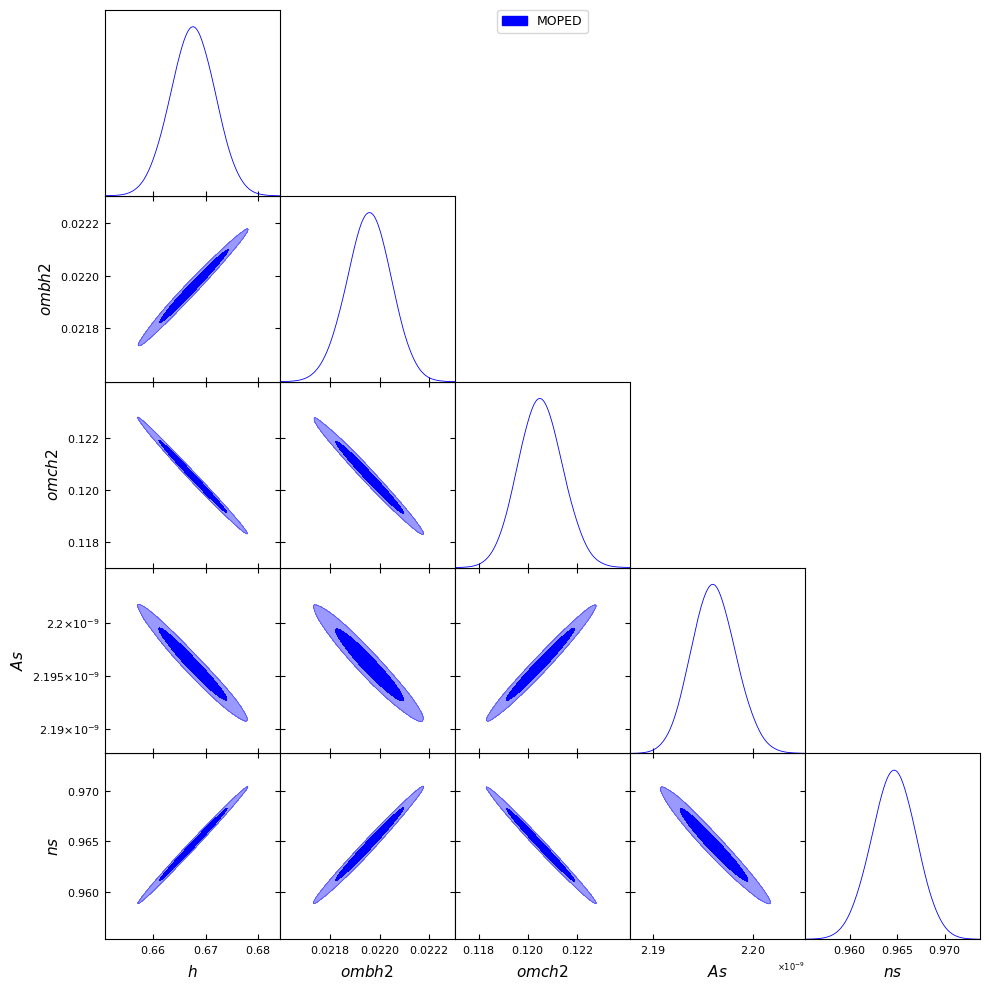

In [99]:
from getdist import plots
from getdist import MCSamples
%matplotlib inline

param_names = ["param1", "param2", 'param3', 'param4', 'param5']
param_labels = ["h", "ombh2", 'omch2', 'As', 'ns']

mcmc_samples = MCSamples(samples=data_reshape, names=param_names, labels=param_labels)
moped_samples = MCSamples(samples=samples, names=param_names, labels=param_labels)
g = plots.get_subplot_plotter()
g.triangle_plot([moped_samples], filled=True, contour_colors=['blue'],
               legend_labels=['MOPED'])

In [77]:
print(samples[0])

[6.7448795e-01 2.2090597e-02 1.1901729e-01 2.1928528e-09 9.6821630e-01]


In [79]:
print(data_reshape[0])

[6.740524e-01 2.199509e-02 1.199580e-01 2.334266e-09 9.673025e-01]


In [96]:
def simulator_sbc(thetas):
    output = []
    for params in tqdm(thetas):
        res = sim_wrapper(params)
        output.append(res)
    return torch.tensor(output, dtype = torch.float32)

num_sbc_runs = 1000  # choose a number of sbc runs, should be ~100s or ideally 1000
# generate ground truth parameters and corresponding simulated observations for SBC.
thetas = prior.sample((num_sbc_runs,))
xs = simulator_sbc(thetas)

100%|██████████| 1000/1000 [26:46<00:00,  1.61s/it]


Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

kolmogorov-smirnov p-values 
check_stats['ks_pvals'] = [3.4995881e-24 4.2724450e-25 7.9129359e-27 2.7632915e-16 4.3432098e-30]
c2st accuracies 
check_stats['c2st_ranks'] = [0.524  0.5285 0.522  0.5205 0.541 ]


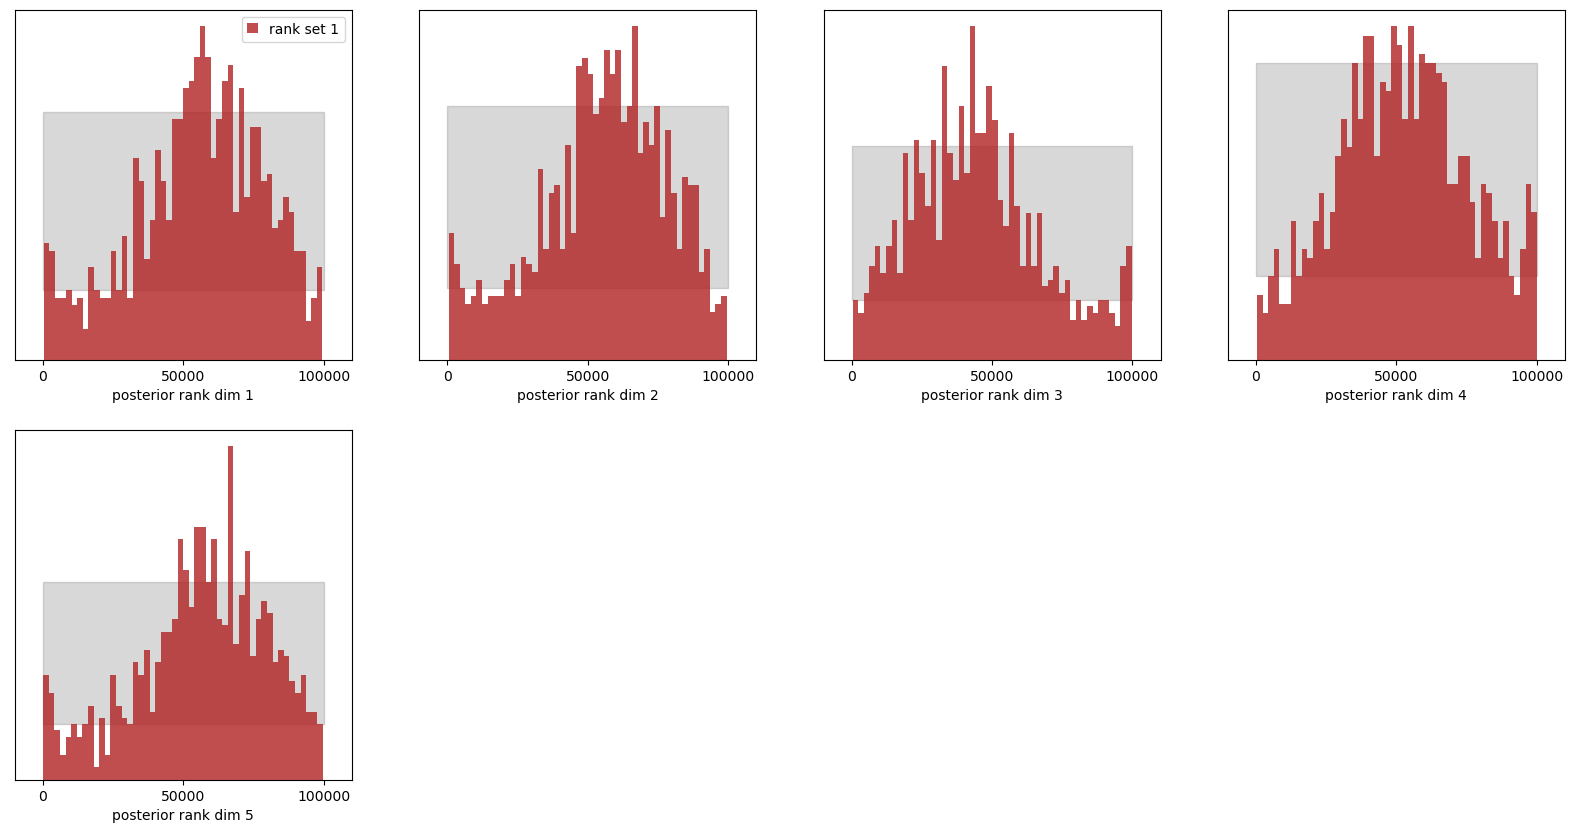

In [97]:
from sbi.analysis import check_sbc, run_sbc, get_nltp, sbc_rank_plot
num_posterior_samples = 100000
ranks, dap_samples = run_sbc(
    thetas, xs, posterior, num_posterior_samples=num_posterior_samples)
check_stats = check_sbc(ranks, thetas, dap_samples, num_posterior_samples=num_posterior_samples)
print(
    f"kolmogorov-smirnov p-values \ncheck_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}"
)
print(
    f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}"
)
from sbi.analysis import sbc_rank_plot

f, ax = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=num_posterior_samples,
    plot_type="hist",
    num_bins=None,  # by passing None we use a heuristic for the number of bins.
)

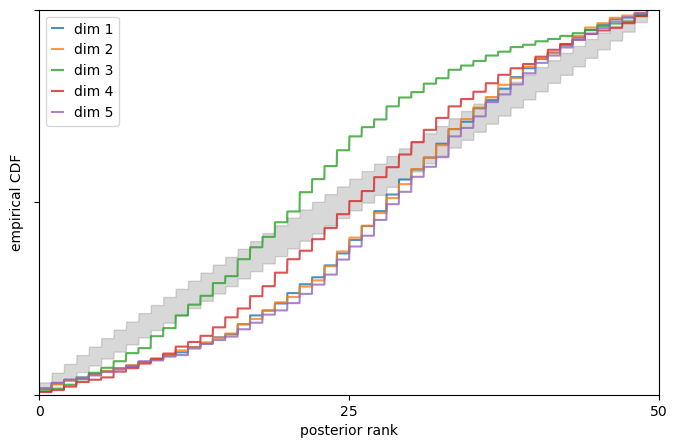

In [98]:
f, ax = sbc_rank_plot(ranks, 1000, plot_type="cdf")

In [32]:
f, ax = sbc_rank_plot(ranks, 1000, plot_type="cdf", 
labels = [r"H_0 / 100", r"100 \Omega_b h^2", r'\Omega_c h^2', r'\ln 10^{10} A_s', r'n_s'])

NameError: name 'ranks' is not defined

## SBI MOPED ROUNDS

In [10]:
import torch

from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis

_ = torch.manual_seed(0)

import camb
import healpy as hp
import pickle
path_to_file = '/Users/aisulu/Desktop/moped_sbi/cosmoped'
if path_to_file not in sys.path:
    sys.path.append(path_to_file)

from cosmoped_likelihood import CosMOPED

In [11]:
path='LambdaCDM/'
TT2018=CosMOPED(path, year=2018, spectra='TT', use_low_ell_bins=False)
compression_vector_dict, compressed_data_dict = TT2018.read_compression_vectors_and_compressed_data(path)
compress_vec_h = compression_vector_dict['h']
compress_vec_ombh2 = compression_vector_dict['omega_b']
compress_vec_omch2 = compression_vector_dict['omega_cdm']
compress_vec_As = compression_vector_dict['A_s']
compress_vec_ns = compression_vector_dict['n_s']
def sim(params):
    # Create a set of cosmological parameters
    pars = camb.CAMBparams()
    H0 = params[0] * 100
    As = params[3]
    pars.set_cosmology(H0=H0, ombh2=params[1], omch2=params[2])
    pars.InitPower.set_params(As=As, ns=params[4])
    pars.set_for_lmax(2500, lens_potential_accuracy=0)

    # Get the results from CAMB
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
    cl = powers['total'][:, 0]
    nside = 1024
    cmb_map = hp.sphtfunc.synfast(cl, nside=nside)
    dl_hats = hp.sphtfunc.anafast(cmb_map)
    dltt = dl_hats[2:2509]
    ells = np.arange(2510)[2:2509]
    return dltt, ells

def compress(dltt, ells):
    fac = fac=ells*(ells+1)/(2*np.pi)
    cltt = dltt/fac
    return [compress_vec_h.dot(cltt), compress_vec_ombh2.dot(cltt), compress_vec_omch2.dot(cltt), compress_vec_As.dot(cltt),
            compress_vec_ns.dot(cltt)]

def sim_wrapper(param):
    dltt, ells = sim(param)
    return compress(dltt, ells)

observed_params = torch.tensor([0.67, 0.022, 0.120, 2.1955e-9, 0.966])

# Generate the observed dataset
observed_dataset = sim_wrapper(observed_params)
print(observed_dataset )

[-145.3690264068416, -320.8628916321949, -267.86721982340964, 414.7522281410404, 10.820725735357561]


In [12]:
parameter_min = [0.50, 0.017, 0.095, 1e-10*np.exp(3.00), 0.9]
parameter_max = [0.90, 0.03, 0.17,1e-10*np.exp(3.15), 1.07]

# Define prior for all parameters
prior = utils.BoxUniform(low=torch.as_tensor(parameter_min),
                         high=torch.as_tensor(parameter_max))

simulator, prior = prepare_for_sbi(sim_wrapper, prior)

In [13]:
inference = SNPE(prior=prior)

In [22]:
num_rounds = 5
x_o = observed_dataset

posteriors = []
proposal = prior

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=3000)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Running 3000 simulations.:   0%|          | 0/3000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.

Drawing 3000 posterior samples:   0%|          | 0/3000 [00:00<?, ?it/s]

Running 3000 simulations.:   0%|          | 0/3000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.

Drawing 3000 posterior samples:   0%|          | 0/3000 [00:00<?, ?it/s]

Running 3000 simulations.:   0%|          | 0/3000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 44 epochs.

Drawing 3000 posterior samples:   0%|          | 0/3000 [00:00<?, ?it/s]

Running 3000 simulations.:   0%|          | 0/3000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 58 epochs.

Drawing 3000 posterior samples:   0%|          | 0/3000 [00:00<?, ?it/s]

Running 3000 simulations.:   0%|          | 0/3000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 26 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

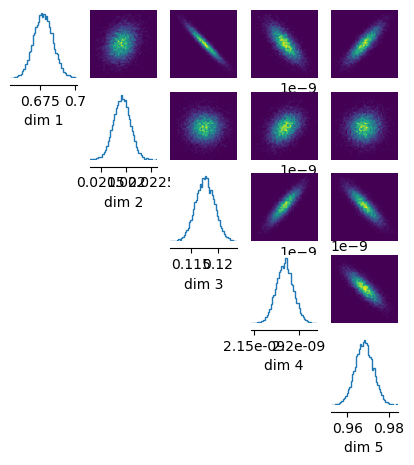

In [23]:
posterior_samples = posterior.sample((10000,), x=x_o)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples,  figsize=(5, 5)
)

In [24]:
import pickle
with open ('posterioir_5rounds_3000_moped,pkl', 'wb') as file:
    pickle.dump(posteriors, file)

In [26]:
np.save('posterior_samples_5_rounds_3000.npy', posterior_samples)

In [27]:
def sim_sbc(pars_set):
    output = []
    for params in tqdm(pars_set):
        cl = sim_wrapper(params)
        output.append(cl)
    return torch.tensor(output)

parameter_min = [0.60, 0.017, 0.095, 1e-10*np.exp(3.00), 0.9]
parameter_max = [0.80, 0.025, 0.17,1e-10*np.exp(3.15), 1.01]

# Define prior for all parameters
prior = utils.BoxUniform(low=torch.as_tensor(parameter_min),
                         high=torch.as_tensor(parameter_max))

In [28]:
num_sbc_runs = 1_000  # choose a number of sbc runs, should be ~100s or ideally 1000
# generate ground truth parameters and corresponding simulated observations for SBC.
thetas = prior.sample((num_sbc_runs,))
xs = sim_sbc(thetas)

100%|██████████| 1000/1000 [1:44:54<00:00,  6.29s/it]


In [33]:
from sbi.analysis import check_sbc, run_sbc, get_nltp, sbc_rank_plot
num_posterior_samples = 100000
ranks, dap_samples = run_sbc(
    thetas, xs, posterior, num_posterior_samples=num_posterior_samples)
check_stats = check_sbc(ranks, thetas, dap_samples, num_posterior_samples=num_posterior_samples)
print(
    f"kolmogorov-smirnov p-values \ncheck_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}"
)
print(
    f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}"
)
from sbi.analysis import sbc_rank_plot

f, ax = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=num_posterior_samples,
    plot_type="hist",
    num_bins=None,  # by passing None we use a heuristic for the number of bins.
)

Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

                    accepted. It may take a long time to collect the remaining
                    100000 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.


KeyboardInterrupt: 